In [9]:
from genome_tools import plotting

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

from pylab import rcParams
rcParams['pdf.fonttype'] = 42

In [11]:
import numpy as np

### Plot ideogram

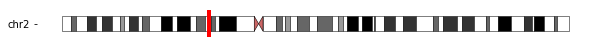

In [12]:
fig,ax=plt.subplots()

plotting.ideogram().render(ax, "chr2", 70000000)

fig.set_size_inches(10, 0.5)

### Plot motif logo

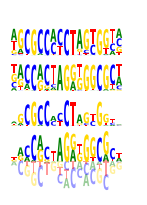

In [15]:
fig=plt.figure()

#You must set the figure size first, otherwise it will not render PWM properly
fig.set_size_inches(2, 3)

gs=gridspec.GridSpec(4, 1, height_ratios=[1,1,1,2])

mat=np.loadtxt("/home/jvierstra/data/motifs/moods/GRCh38_no_alts.alldbs.1e-4/pfm/CTCF_C2H2_1.pfm")

# default
ax=fig.add_subplot(gs[0,0])
plotting.pwm(mat).render(fig, ax, type='def')

# reverse-complement
ax=fig.add_subplot(gs[1,0])
plotting.pwm(mat).render(fig, ax, type='def', rc=True)

# bit-score style
ax=fig.add_subplot(gs[2,0])
plotting.pwm(mat).render(fig, ax, type='ic')

# affinity style
ax=fig.add_subplot(gs[3,0])
plotting.pwm(mat).render(fig, ax, type='affinity', rc=True)